In [27]:
# Cell 1: Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.interpolate import interp1d
import torch
from tqdm import tqdm
import torch
from torch.distributions import Distribution, Independent, Uniform, Dirichlet
from sbi.utils.user_input_checks import process_prior, process_simulator
from sbi.inference import SNPE
from sbi.utils.user_input_checks import prepare_for_sbi
from functools import partial

from sklearn.metrics import r2_score


In [ ]:
λ_grid = np.arange(500, 801, 1)
fluor_names = ['JF525','JF552','JF608','JFX673','JF722']
spectra_dir = Path("../data/spectra_npz")

# Cell 2: Load and interpolate spectra
def load_and_interpolate(fluor_names, spectra_dir, λ_grid):
    spectra = {}
    for name in fluor_names:
        path = spectra_dir / f"{name}.npz"
        data = np.load(path)
        wl = data["wavelengths_emission"]
        em = data["emission"] / data["emission"].max()
        interp = interp1d(wl, em, bounds_error=False, fill_value=0.0)
        spectra[name] = interp(λ_grid)
    return spectra

interpolated_emissions = load_and_interpolate(fluor_names, spectra_dir, λ_grid)
# Step 1: Load NADH spectrum
nadh_path = spectra_dir / "NADH.npz"
nadh_data = np.load(nadh_path)
nadh_wl = nadh_data["wavelengths_emission"]
nadh_em = nadh_data["emission"]
nadh_em /= nadh_em.max()  # normalize

# Interpolate onto λ_grid
from scipy.interpolate import interp1d
interp_nadh = interp1d(nadh_wl, nadh_em, bounds_error=False, fill_value=0)
nadh_em_interp = interp_nadh(λ_grid)
# Fixed σ and λ from your optimal configuration


optimal_sigmas = np.array([34.21, 22.63, 32.11, 36.32, 36.32])
optimal_centers = np.array([547.62, 576.38, 635.90, 684.48, 742.00])
sigma_min = 15.0
sigma_max = 55.0
center_width = 40.0

In [ ]:

amp_prior = Dirichlet(torch.ones(5))  # shape [5]
σ_prior = Independent(Uniform(torch.full((5,), sigma_min), torch.full((5,), sigma_max)), 1)  # shape [5]
λ_prior = Independent(Uniform(torch.tensor(optimal_centers - center_width), torch.tensor(optimal_centers + center_width)), 1)  # shape [5]
bg_amp_prior = Independent(Uniform(torch.tensor([10.0]), torch.tensor([100.0])), 1)  # shape [1]

class CustomFlatPrior(Distribution):
    def __init__(self, amp_prior, σ_prior, λ_prior, bg_prior):
        super().__init__()
        self.amp = amp_prior
        self.σ = σ_prior
        self.λ = λ_prior
        self.bg = bg_prior

    def sample(self, sample_shape=torch.Size()):
        amp = self.amp.sample(sample_shape)
        σ   = self.σ.sample(sample_shape)
        λ   = self.λ.sample(sample_shape)
        bg  = self.bg.sample(sample_shape)
        return torch.cat([amp, σ, λ, bg], dim=-1)

    def log_prob(self, θ):
        # Flat prior
        return torch.zeros(θ.shape[:-1])

    @property
    def support(self):
        # Disable internal constraint checks
        raise NotImplementedError("Support check bypassed for custom prior.")
prior = CustomFlatPrior(
    amp_prior=Dirichlet(torch.ones(5)),
    σ_prior=Uniform(torch.full((5,), 5.0), torch.full((5,), 50.0)),
    λ_prior=Uniform(torch.tensor(optimal_centers - 30), torch.tensor(optimal_centers + 30)),
    bg_prior=Uniform(torch.tensor([10.0]), torch.tensor([100.0]))
)

In [ ]:
from numpy.random import default_rng
rng = default_rng(seed=42)
num_samples = 3000  # or however many you want
alpha = np.ones(5)  # uniform Dirichlet
amplitude_grid = rng.dirichlet(alpha, size=num_samples)
# Then simulate
x_fixed = batch_simulator_fixed_filters(amplitude_grid, λ_grid, interpolated_emissions, nadh_em_interp)


In [ ]:
from numpy.random import default_rng
rng = default_rng(seed=42)
num_samples = 3000  # or however many you want
alpha = np.ones(5)  # uniform Dirichlet
amplitude_grid = rng.dirichlet(alpha, size=num_samples)
# Then simulate
x_fixed = batch_simulator_fixed_filters(amplitude_grid, λ_grid, interpolated_emissions, nadh_em_interp)


In [ ]:
from numpy.random import default_rng
rng = default_rng(seed=42)
num_samples = 3000  # or however many you want
alpha = np.ones(5)  # uniform Dirichlet
amplitude_grid = rng.dirichlet(alpha, size=num_samples)
# Then simulate
x_fixed = batch_simulator_fixed_filters(amplitude_grid, λ_grid, interpolated_emissions, nadh_em_interp)


In [ ]:
from numpy.random import default_rng
rng = default_rng(seed=42)
num_samples = 3000  # or however many you want
alpha = np.ones(5)  # uniform Dirichlet
amplitude_grid = rng.dirichlet(alpha, size=num_samples)
# Then simulate
x_fixed = batch_simulator_fixed_filters(amplitude_grid, λ_grid, interpolated_emissions, nadh_em_interp)


In [9]:
prior.sample([2,])

tensor([[1.8513e-01, 1.9505e-02, 1.0833e-01, 6.6441e-02, 6.2060e-01, 1.3690e+01,
         4.2314e+01, 2.3633e+01, 3.1075e+01, 2.0663e+01, 5.6331e+02, 5.9606e+02,
         6.4416e+02, 7.1183e+02, 7.2202e+02, 1.9026e+01],
        [4.3905e-01, 2.3566e-01, 2.6149e-02, 1.7965e-01, 1.1949e-01, 3.5089e+01,
         3.1092e+01, 3.0384e+01, 2.9340e+01, 2.7166e+01, 5.7660e+02, 5.7628e+02,
         6.4272e+02, 6.7675e+02, 7.4171e+02, 2.3087e+01]], dtype=torch.float64)

In [10]:
def batch_simulator_fixed_filters(amplitude_batch, λ_grid, interpolated_emissions, nadh_em_interp,
                                  total_dye_photons=3e2, total_background_photons=3e1,
                                  edge_steepness=1.0, rng_seed=123):
    """
    Simulate photon counts for fixed microscope filter configuration.
    
    amplitude_batch: (B, 5) array of dye amplitudes
    Returns: (B, 5) tensor of channel photon counts
    """
    B = amplitude_batch.shape[0]
    C = 5
    x_batch = []

    rng = np.random.default_rng(seed=rng_seed)

    # Build filters once
    filters = np.stack([
        1 / (1 + np.exp(-(λ_grid - (c - w/2)) * edge_steepness)) *
        1 / (1 + np.exp((λ_grid - (c + w/2)) * edge_steepness))
        for c, w in zip(optimal_centers, optimal_sigmas)
    ])  # (5, λ)

    for amps in amplitude_batch:
        # Dye signals
        dye_signals = np.zeros((5, C))
        for i, (name, amp) in enumerate(zip(interpolated_emissions.keys(), amps)):
            spectrum = interpolated_emissions[name]
            dye_signals[i] = amp * np.sum(filters * spectrum, axis=1)

        signal_sum = dye_signals.sum()
        dye_photon_signal = dye_signals.sum(axis=0) / signal_sum * total_dye_photons if signal_sum > 0 else np.zeros(C)

        # NADH background
        bg_signal = np.sum(filters * nadh_em_interp, axis=1)
        bg_signal /= bg_signal.sum() if bg_signal.sum() > 0 else 1
        background_photon_signal = bg_signal * total_background_photons

        total_signal = dye_photon_signal + background_photon_signal
        noisy_counts = rng.poisson(total_signal).astype(np.float32)

        x_batch.append(noisy_counts)

    return torch.tensor(np.array(x_batch), dtype=torch.float32)


In [11]:
# ==== 2. Define the wrapped simulator ====
def wrapped_sim(theta, λ_grid, interpolated_emissions, nadh_em_interp):
    # theta shape: (B, 16) → [amp_vec(5), σ(5), λ(5), bg_amp(1)]
    theta = theta.reshape(-1, 16)
    return batch_simulator_fixed_filters(theta, λ_grid, interpolated_emissions, nadh_em_interp)  # your existing simulator

# Set up partially applied simulator for SBI
simulator_partial = partial(wrapped_sim, 
                             λ_grid=λ_grid, 
                             interpolated_emissions=interpolated_emissions, 
                             nadh_em_interp=nadh_em_interp)

# Prepare simulator and prior

simulator = process_simulator(simulator_partial, prior, is_numpy_simulator=False)
prior, _, _ = process_prior(prior)
# simulator, prior = prepare_for_sbi(simulator_partial, prior)


/tmp/ipykernel_2294332/2318258532.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dye_signals[i] = amp * np.sum(filters * spectrum, axis=1)
/tmp/ipykernel_2294332/2318258532.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dye_signals[i] = amp * np.sum(filters * spectrum, axis=1)


In [16]:
num_train = 30000
θ_train = prior.sample((num_train,))  # shape: (3000, 16)
x_train = simulator(θ_train)          # shape: (3000, 5)

/tmp/ipykernel_2294332/2318258532.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  dye_signals[i] = amp * np.sum(filters * spectrum, axis=1)
/tmp/ipykernel_2294332/2318258532.py:28: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  dye_signals[i] = amp * np.sum(filters * spectrum, axis=1)


In [17]:
inference = SNPE(prior=prior)
inference.append_simulations(θ_train, x_train)
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

 Neural network successfully converged after 246 epochs.

/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/groups/spruston/home/moharb/mambaforge/envs/sbi_env/lib/python3.10/site-packages/sbi/inference/potentials/posterior_based_potential.py:54: UserWarning: The passed prior has no mean or stddev attribute, estimating them from samples to build affimed standardizing transform.
  theta_transform = mcmc_transform(


In [28]:
posterior_means_fixed = []
posterior_stds_fixed = []
amp_trues = []
bg_trues = []
sigma_means_all = []
center_means_all = []
r2_list = []
for i in tqdm(range(len(x_train))):
    x_i = x_train[i]
    θ_true = θ_train[i]

    amp_true = θ_true[:5].numpy()
    σ_true = θ_true[5:10].numpy()
    λ_true = θ_true[10:15].numpy()
    bg_true = θ_true[15].item()

    samples = posterior.sample((100,), x=x_i, show_progress_bars=False)
    amp_samples = samples[:, :5].numpy()

    amp_pred = amp_samples.mean(axis=0)
    amp_std = amp_samples.std(axis=0)

    # Store
    amp_trues.append(amp_true)
    posterior_means_fixed.append(amp_pred)
    posterior_stds_fixed.append(amp_std)
    bg_trues.append(bg_true)
    sigma_means_all.append(σ_true)
    center_means_all.append(λ_true)
    r2_list.append(r2_score(amp_true, amp_pred))

# Convert to DataFrame
df = pd.DataFrame({
    **{f"amp_true_{i}": np.array(amp_trues)[:, i] for i in range(5)},
    **{f"amp_pred_{i}": np.array(posterior_means_fixed)[:, i] for i in range(5)},
    **{f"amp_std_{i}": np.array(posterior_stds_fixed)[:, i] for i in range(5)},
    **{f"sigma_mean_{i}": np.array(sigma_means_all)[:, i] for i in range(5)},
    **{f"center_mean_{i}": np.array(center_means_all)[:, i] for i in range(5)},
    "bg_true": bg_trues,
    "r2": r2_list
})

100%|██████████| 30000/30000 [08:21<00:00, 59.83it/s]


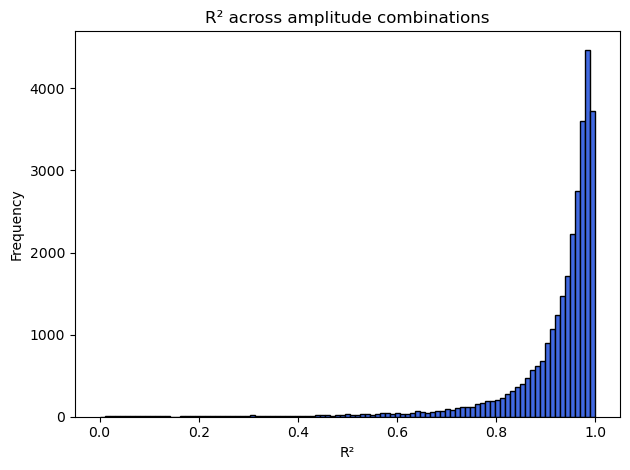

In [31]:
plt.hist(r2_all, bins=np.linspace(0,1,100), color='royalblue', edgecolor='black')
plt.title("R² across amplitude combinations")
plt.xlabel("R²")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


/tmp/ipykernel_2294332/687902726.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ch_df.groupby(['σ_bin', 'λ_bin'])['r2'].mean().unstack()


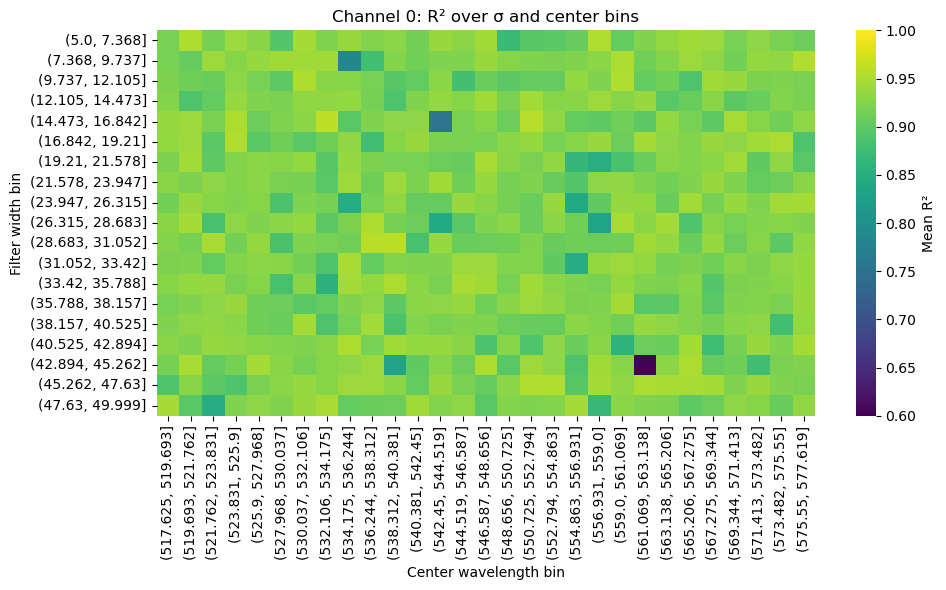

/tmp/ipykernel_2294332/687902726.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ch_df.groupby(['σ_bin', 'λ_bin'])['r2'].mean().unstack()


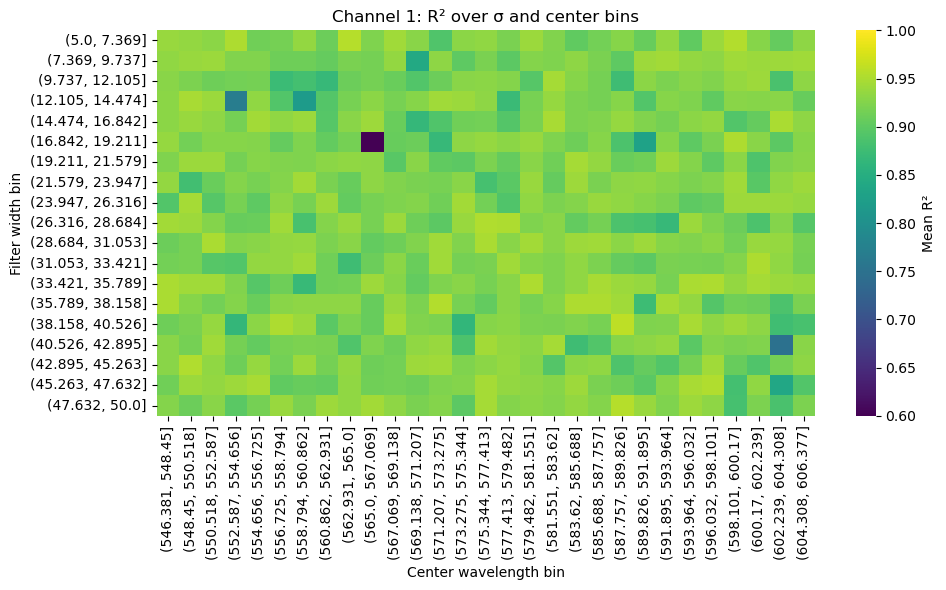

/tmp/ipykernel_2294332/687902726.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ch_df.groupby(['σ_bin', 'λ_bin'])['r2'].mean().unstack()


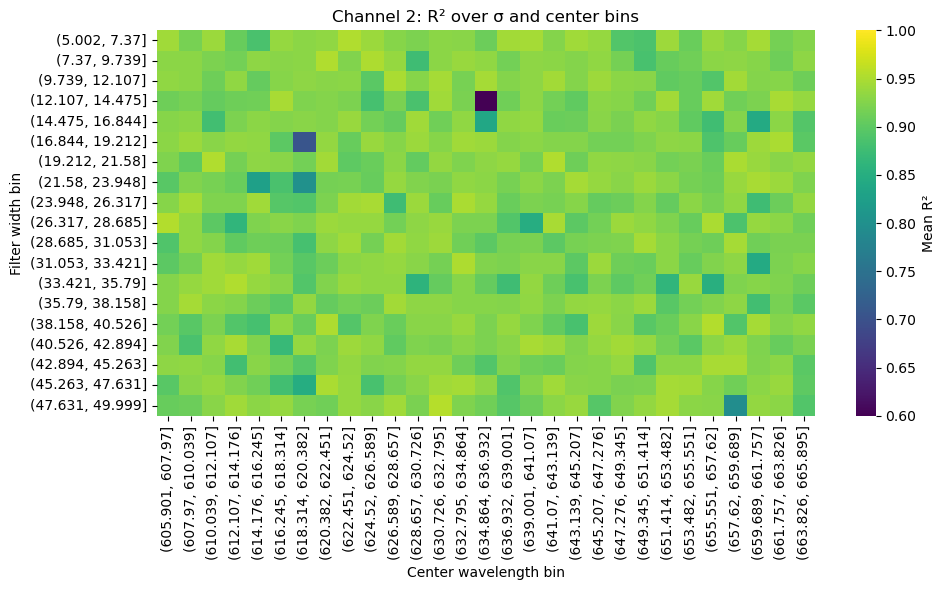

/tmp/ipykernel_2294332/687902726.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ch_df.groupby(['σ_bin', 'λ_bin'])['r2'].mean().unstack()


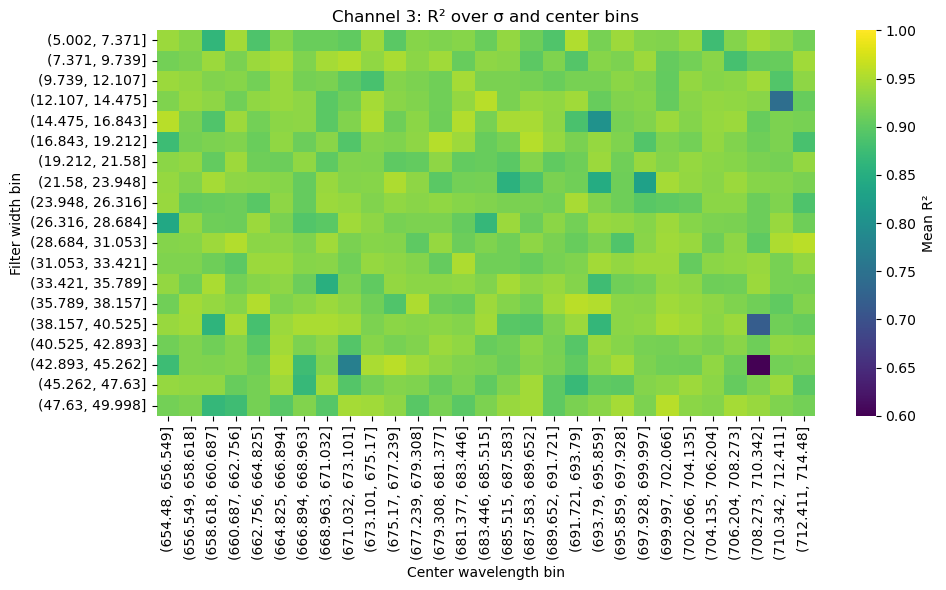

/tmp/ipykernel_2294332/687902726.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = ch_df.groupby(['σ_bin', 'λ_bin'])['r2'].mean().unstack()


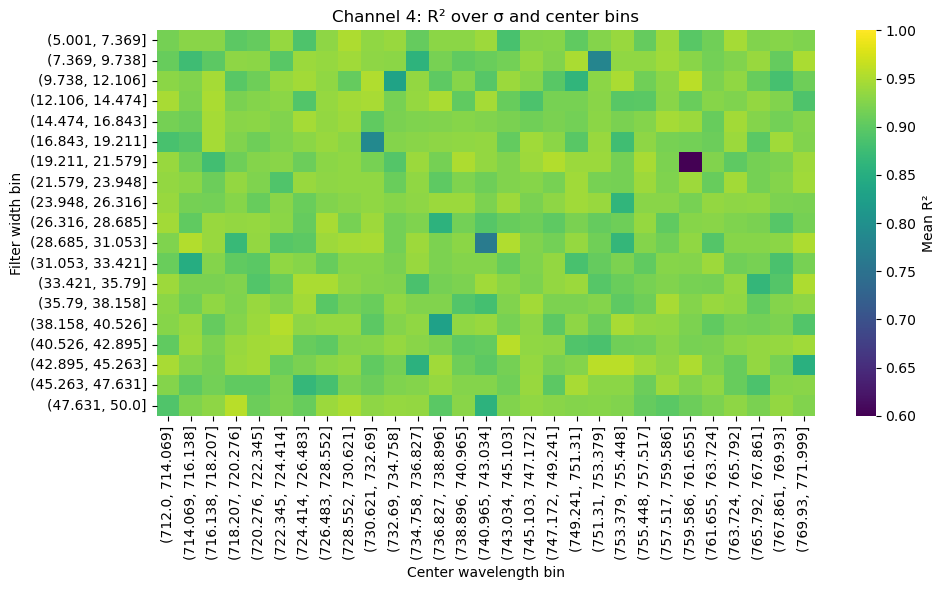

channel_0: Optimal σ ≈ 15.66 nm, λ ≈ 533.14 nm
channel_1: Optimal σ ≈ 39.34 nm, λ ≈ 588.79 nm
channel_2: Optimal σ ≈ 48.81 nm, λ ≈ 631.76 nm
channel_3: Optimal σ ≈ 36.97 nm, λ ≈ 692.76 nm
channel_4: Optimal σ ≈ 44.08 nm, λ ≈ 754.41 nm


In [33]:
optimal_configurations = {}

# Bounds for binning — use prior min/max directly if available
σ_bounds = (np.min(df[[f'sigma_mean_{i}' for i in range(5)]].values, axis=0),
            np.max(df[[f'sigma_mean_{i}' for i in range(5)]].values, axis=0))
λ_bounds = (np.min(df[[f'center_mean_{i}' for i in range(5)]].values, axis=0),
            np.max(df[[f'center_mean_{i}' for i in range(5)]].values, axis=0))

for ch in range(5):
    ch_df = pd.DataFrame({
        'sigma': df[f'sigma_mean_{ch}'],
        'center': df[f'center_mean_{ch}'],
        'r2': df['r2']
    })

    # Bin filter widths and centers
    σ_bins = np.linspace(σ_bounds[0][ch], σ_bounds[1][ch], 20)
    λ_bins = np.linspace(λ_bounds[0][ch], λ_bounds[1][ch], 30)

    ch_df['σ_bin'] = pd.cut(ch_df['sigma'], bins=σ_bins)
    ch_df['λ_bin'] = pd.cut(ch_df['center'], bins=λ_bins)

    # Compute mean R² per (σ, λ) bin
    grouped = ch_df.groupby(['σ_bin', 'λ_bin'])['r2'].mean().unstack()

    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(grouped, cmap="viridis", annot=False, 
            vmin=0.6, vmax=1.0, cbar_kws={'label': 'Mean R²'})
    plt.title(f"Channel {ch}: R² over σ and center bins")
    plt.xlabel("Center wavelength bin")
    plt.ylabel("Filter width bin")
    plt.tight_layout()
    plt.show()

    # Extract best performing filter configuration
    max_idx = grouped.stack().idxmax()
    σ_opt = max_idx[0].mid
    λ_opt = max_idx[1].mid
    optimal_configurations[f'channel_{ch}'] = {'σ_opt': σ_opt, 'λ_opt': λ_opt}

# Report optimal configuration for each channel
for ch, vals in optimal_configurations.items():
    print(f"{ch}: Optimal σ ≈ {vals['σ_opt']:.2f} nm, λ ≈ {vals['λ_opt']:.2f} nm")

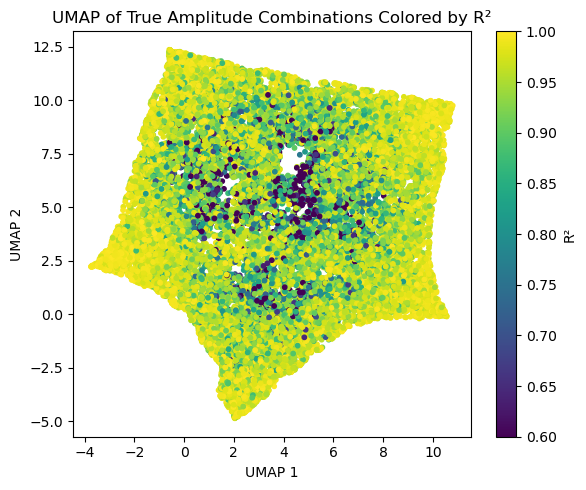

In [35]:
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

# Extract amplitude vectors from df
amplitude_matrix = df[[f"amp_true_{i}" for i in range(5)]].to_numpy()

# Apply UMAP
proj = UMAP(n_components=2, n_neighbors=20).fit_transform(amplitude_matrix)

# Plot with R² values
plt.figure(figsize=(6, 5))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=df['r2'], cmap='viridis', s=10, vmin=0.6, vmax=1.0)
plt.colorbar(sc, label='R²')
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.title("UMAP of True Amplitude Combinations Colored by R²")
plt.tight_layout()
plt.show()

/tmp/ipykernel_2294332/2423327883.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


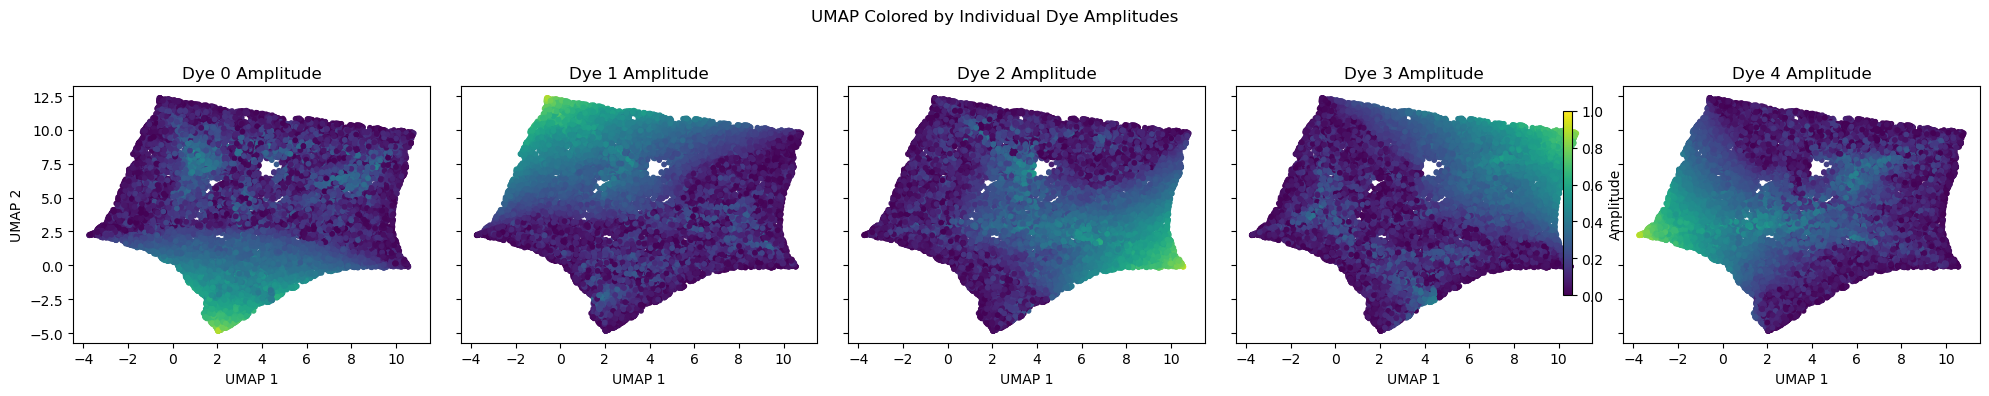

In [36]:
# Plot UMAP colored by each dye amplitude
fig, axes = plt.subplots(1, 5, figsize=(20, 4), sharex=True, sharey=True)

for i in range(5):
    sc = axes[i].scatter(proj[:, 0], proj[:, 1], c=amplitude_matrix[:, i],
                         cmap='viridis', s=10, vmin=0, vmax=1)
    axes[i].set_title(f"Dye {i} Amplitude")
    axes[i].set_xlabel("UMAP 1")
    if i == 0:
        axes[i].set_ylabel("UMAP 2")

fig.colorbar(sc, ax=axes.ravel().tolist(), shrink=0.6, label='Amplitude')
plt.suptitle("UMAP Colored by Individual Dye Amplitudes")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()